# 1. Loading MNIST Dataset

In [27]:
import gzip
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torchsummary import summary

In [28]:
class MNISTDataset(Dataset):
    def __init__(self, images_path, labels_path):
        self.images = self._read_images(images_path)
        self.labels = self._read_labels(labels_path)

    def _read_images(self, filepath):
        with open(filepath, 'rb') as f:
            magic, num_images, rows, cols = np.frombuffer(f.read(16), dtype=np.dtype('>i4'))
            data = np.frombuffer(f.read(), dtype=np.uint8)
            data = data.reshape(num_images, 1, rows, cols).astype(np.float32) / 255.0
        return data

    def _read_labels(self, filepath):
        with open(filepath, 'rb') as f:
            magic, num_labels = np.frombuffer(f.read(8), dtype=np.dtype('>i4'))
            labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

In [29]:
# Adjust the paths to your files
train_images_path = r'C:\Users\Surya Teja\Desktop\Project\MNIST Labelled Dataset\train-images.idx3-ubyte'
train_labels_path = r'C:\Users\Surya Teja\Desktop\Project\MNIST Labelled Dataset\train-labels.idx1-ubyte'
test_images_path = r'C:\Users\Surya Teja\Desktop\Project\MNIST Labelled Dataset\t10k-images.idx3-ubyte'
test_labels_path = r'C:\Users\Surya Teja\Desktop\Project\MNIST Labelled Dataset\t10k-labels.idx1-ubyte'

In [30]:
# Create the dataset objects
train_dataset = MNISTDataset(train_images_path, train_labels_path)
test_dataset = MNISTDataset(test_images_path, test_labels_path)

In [31]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Displaying 5 random images from the dataset

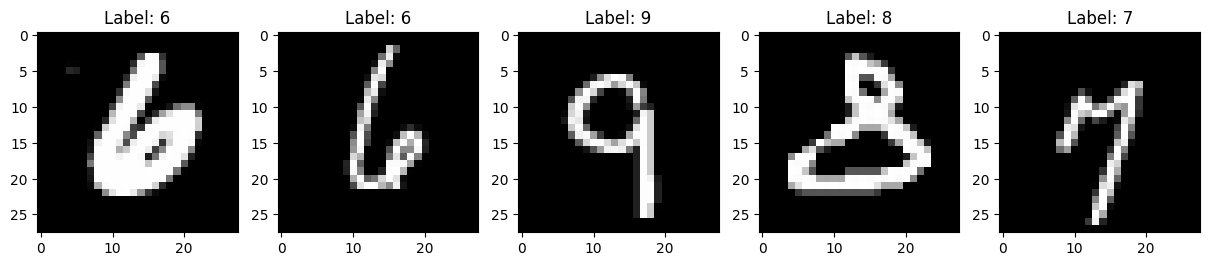

In [32]:
# Define the class labels for MNIST dataset
class_labels = "0123456789"

# Function to display images from the dataset
def display_images(images, labels, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.set_title(f"Label: {class_labels[labels[i]]}")
        ax.axis('on')
    plt.show()

# Display some sample images from the training dataset
sample_images, sample_labels = next(iter(train_loader))
display_images(sample_images, sample_labels)

# 2. Preprocessing the Data

In [33]:
# Define the transformation
transform = transforms.Compose([
    transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32)),  # Convert NumPy array to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the tensor
])

In [34]:
class MNISTDataset(Dataset):
    def __init__(self, images_path, labels_path, transform=None):
        self.images = self._read_images(images_path)
        self.labels = self._read_labels(labels_path)
        self.transform = transform

    def _read_images(self, filepath):
        with open(filepath, 'rb') as f:
            magic, num_images, rows, cols = np.frombuffer(f.read(16), dtype=np.dtype('>i4'))
            data = np.frombuffer(f.read(), dtype=np.uint8)
            data = data.reshape(num_images, 1, rows, cols).astype(np.float32) / 255.0
        return data

    def _read_labels(self, filepath):
        with open(filepath, 'rb') as f:
            magic, num_labels = np.frombuffer(f.read(8), dtype=np.dtype('>i4'))
            labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# 3. Splitting the Dataset

In [35]:
# Create the dataset objects with transformations
train_dataset = MNISTDataset(train_images_path, train_labels_path, transform=transform)
test_dataset = MNISTDataset(test_images_path, test_labels_path, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

dataset = MNISTDataset(train_images_path, train_labels_path)

In [36]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
for train_index, val_index in kf.split(train_dataset):
    train_subset = torch.utils.data.Subset(train_dataset, train_index)
    val_subset = torch.utils.data.Subset(train_dataset, val_index)
    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_subset, batch_size=64, shuffle=False)

In [37]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 3. Building the Models

## (i) Building the MLP Model

In [12]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Ensure the model is moved to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp_model = MLP().to(device)

MLP_model = MLP()

In [13]:
print(MLP_model)
summary(MLP_model, (1, 28, 28))

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 64]          50,240
       BatchNorm1d-3                   [-1, 64]             128
           Dropout-4                   [-1, 64]               0
            Linear-5                   [-1, 32]           2,080
       BatchNorm1d-6                   [-1, 32]    

## (ii) Building the CNN Model

In [14]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Ensure the model is moved to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SimpleCNN_model = SimpleCNN().to(device)

In [15]:
print(SimpleCNN_model)
summary(SimpleCNN_model, (1, 28, 28))

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 14, 14]          18,496
            Linear-3                  [-1, 128]         401,536
            Linear-4                   [-1, 10]           1,290
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.29
Params size (MB): 1.61
Estimated Total Size (MB): 1.90
----------------------------------------------------------------


## (iii) Building the LeNet-5 Model

In [16]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) 

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = LeNet5()

In [17]:
print(model)
summary(model, (1, 28, 28))

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
            Conv2d-2             [-1, 16, 8, 8]           2,416
            Linear-3                  [-1, 120]          30,840
            Linear-4                   [-1, 84]          10,164
            Linear-5                   [-1, 10]             850
Total params: 44,426
Trainable params: 44,426
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.17
Estimated Total Size 

# 4. Training the Models

In [16]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)
        train_losses.append(running_train_loss / len(train_loader))

        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_accuracy = 100 * correct_val / total_val
        val_accuracies.append(val_accuracy)
        val_losses.append(running_val_loss / len(val_loader))

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Plotting Training and Validation Accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    # Plotting Training and Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return model

## (i) Training the MLP model

Epoch 1/10, Train Loss: 0.9007, Train Accuracy: 71.86%, Validation Loss: 0.2834, Validation Accuracy: 92.06%
Epoch 2/10, Train Loss: 0.6233, Train Accuracy: 81.30%, Validation Loss: 0.2218, Validation Accuracy: 93.50%
Epoch 3/10, Train Loss: 0.5541, Train Accuracy: 83.60%, Validation Loss: 0.2045, Validation Accuracy: 94.15%
Epoch 4/10, Train Loss: 0.5104, Train Accuracy: 85.14%, Validation Loss: 0.1877, Validation Accuracy: 94.55%
Epoch 5/10, Train Loss: 0.4878, Train Accuracy: 85.81%, Validation Loss: 0.1764, Validation Accuracy: 95.06%
Epoch 6/10, Train Loss: 0.4742, Train Accuracy: 86.12%, Validation Loss: 0.1687, Validation Accuracy: 95.31%
Epoch 7/10, Train Loss: 0.4619, Train Accuracy: 86.59%, Validation Loss: 0.1607, Validation Accuracy: 95.49%
Epoch 8/10, Train Loss: 0.4504, Train Accuracy: 86.80%, Validation Loss: 0.1590, Validation Accuracy: 95.47%
Epoch 9/10, Train Loss: 0.4398, Train Accuracy: 87.25%, Validation Loss: 0.1547, Validation Accuracy: 95.56%
Epoch 10/10, Train 

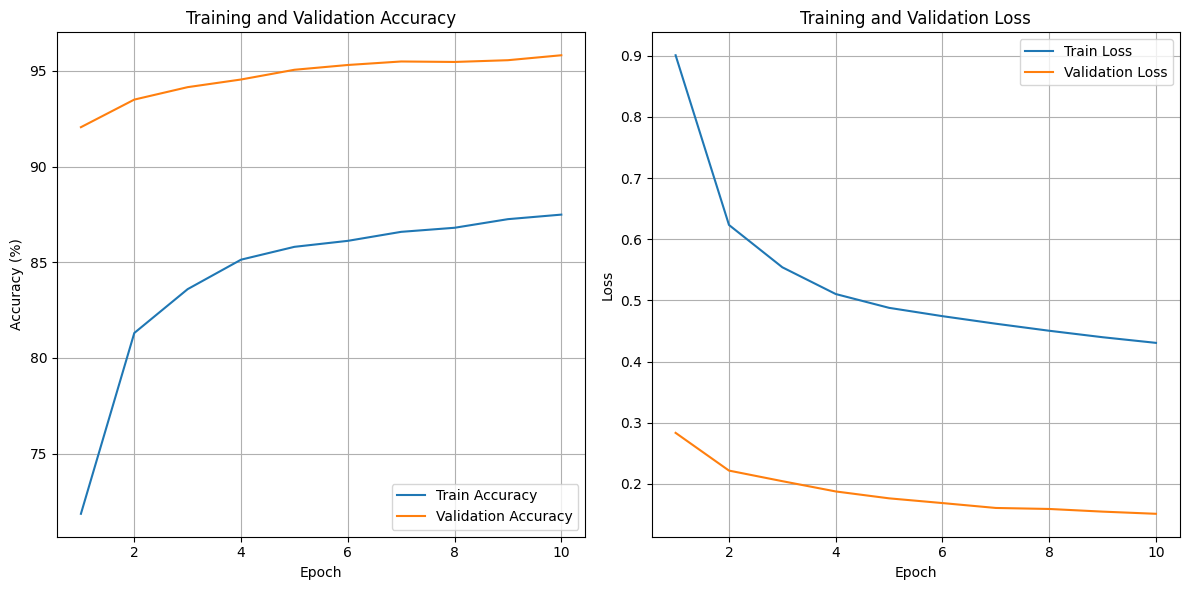

In [19]:
# Instantiate the model, criterion, and optimizer
model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Train the model
MLP_model = train_model(model, train_loader, val_loader, criterion, optimizer, device)

## (ii) Training the CNN Model

Epoch 1/10, Train Loss: 0.2732, Train Accuracy: 91.71%, Validation Loss: 0.0890, Validation Accuracy: 97.43%
Epoch 2/10, Train Loss: 0.0595, Train Accuracy: 98.14%, Validation Loss: 0.0568, Validation Accuracy: 98.32%
Epoch 3/10, Train Loss: 0.0414, Train Accuracy: 98.72%, Validation Loss: 0.0454, Validation Accuracy: 98.71%
Epoch 4/10, Train Loss: 0.0307, Train Accuracy: 99.06%, Validation Loss: 0.0434, Validation Accuracy: 98.82%
Epoch 5/10, Train Loss: 0.0237, Train Accuracy: 99.26%, Validation Loss: 0.0416, Validation Accuracy: 98.83%
Epoch 6/10, Train Loss: 0.0195, Train Accuracy: 99.38%, Validation Loss: 0.0398, Validation Accuracy: 98.92%
Epoch 7/10, Train Loss: 0.0155, Train Accuracy: 99.52%, Validation Loss: 0.0432, Validation Accuracy: 98.72%
Epoch 8/10, Train Loss: 0.0118, Train Accuracy: 99.62%, Validation Loss: 0.0371, Validation Accuracy: 98.90%
Epoch 9/10, Train Loss: 0.0089, Train Accuracy: 99.72%, Validation Loss: 0.0383, Validation Accuracy: 98.98%
Epoch 10/10, Train 

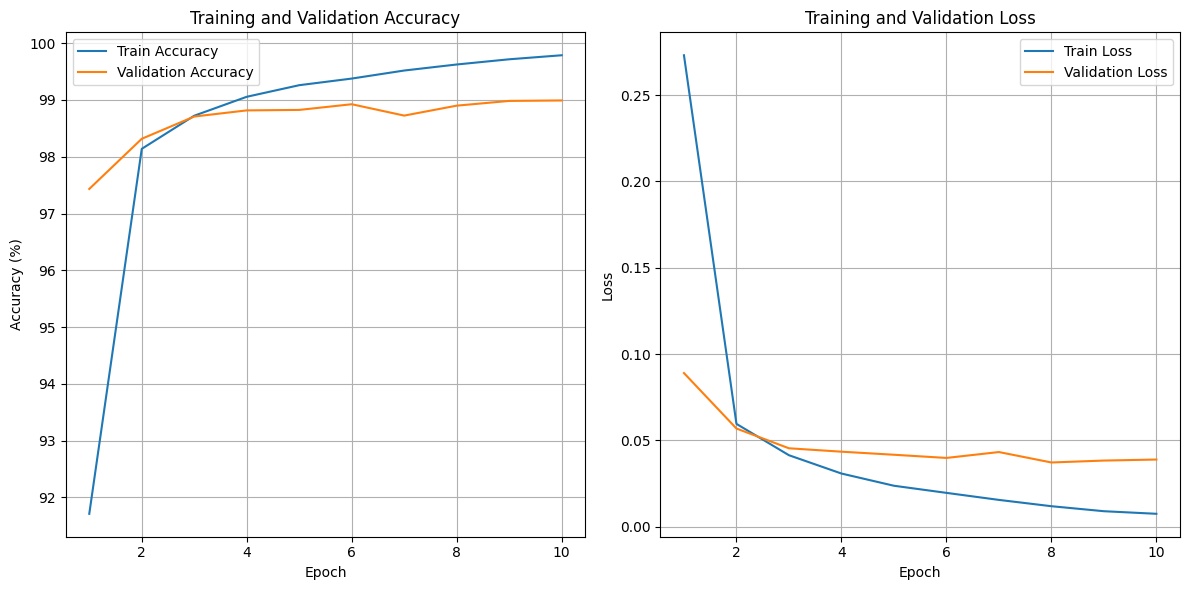

In [33]:
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Train the model
CNN_model = train_model(model, train_loader, val_loader, criterion, optimizer, device)

## (iii) Training the LeNet-5 Model

Epoch 1/10, Train Loss: 0.4621, Train Accuracy: 85.06%, Validation Loss: 0.0842, Validation Accuracy: 97.27%
Epoch 2/10, Train Loss: 0.0693, Train Accuracy: 97.78%, Validation Loss: 0.0639, Validation Accuracy: 98.12%
Epoch 3/10, Train Loss: 0.0482, Train Accuracy: 98.43%, Validation Loss: 0.0521, Validation Accuracy: 98.55%
Epoch 4/10, Train Loss: 0.0373, Train Accuracy: 98.79%, Validation Loss: 0.0667, Validation Accuracy: 98.06%
Epoch 5/10, Train Loss: 0.0303, Train Accuracy: 99.02%, Validation Loss: 0.0526, Validation Accuracy: 98.55%
Epoch 6/10, Train Loss: 0.0249, Train Accuracy: 99.19%, Validation Loss: 0.0495, Validation Accuracy: 98.67%
Epoch 7/10, Train Loss: 0.0229, Train Accuracy: 99.26%, Validation Loss: 0.0467, Validation Accuracy: 98.77%
Epoch 8/10, Train Loss: 0.0187, Train Accuracy: 99.38%, Validation Loss: 0.0529, Validation Accuracy: 98.63%
Epoch 9/10, Train Loss: 0.0142, Train Accuracy: 99.56%, Validation Loss: 0.0468, Validation Accuracy: 98.89%
Epoch 10/10, Train 

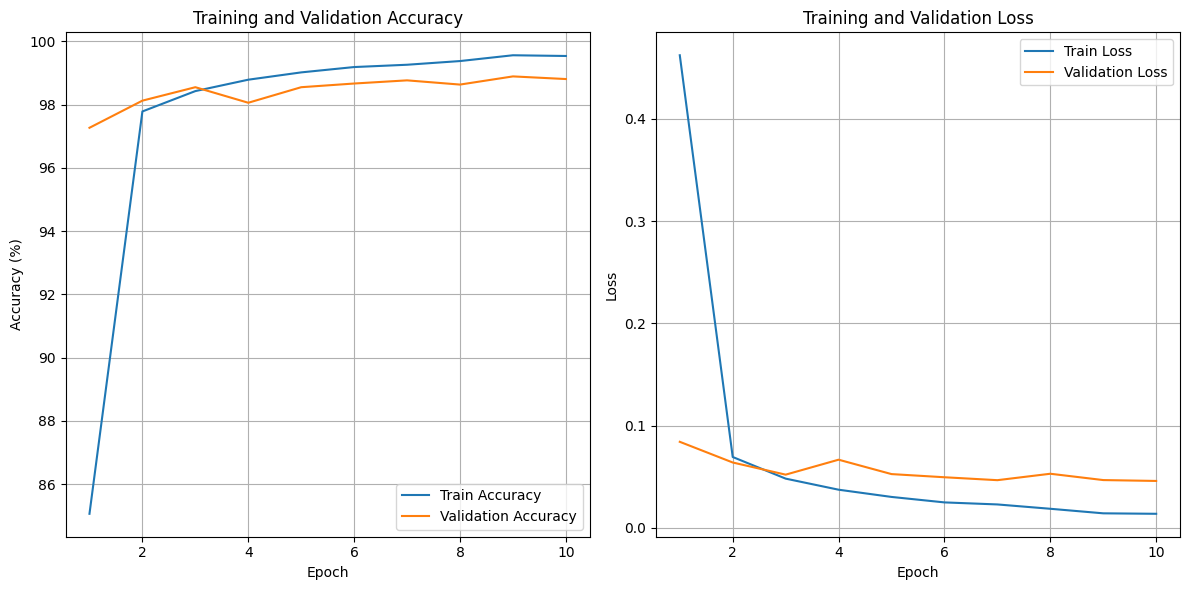

In [29]:
# Instantiate the model, criterion, and optimizer
model = LeNet5().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# Train the model
lenet_model = train_model(model, train_loader, val_loader, criterion, optimizer, device)

# 5. Testing the Model Accuracy

In [21]:
# Evaluate the model
def evaluate_model(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')
    return accuracy

## (i) MLP Model Accuracy

In [22]:
# Evaluate MLP model
mlp_accuracy = evaluate_model(MLP_model, test_loader, device)

Accuracy: 95.63%


## (ii) CNN Model Accuracy

In [34]:
# Evaluate SimpleCNN model
cnn_accuracy= evaluate_model(CNN_model, test_loader, device)

Accuracy: 99.15%


## (iii) LeNet-5 Model Accuracy

In [30]:
# Evaluate LeNet5 model
lenet_accuracy = evaluate_model(lenet_model, test_loader, device)

Accuracy: 98.85%


# 6. Visualising randomly some images in the test set as well as their predicted labels

In [25]:
import random

def test_random_images(model, test_dataset, device, num_images=5):
    model.eval()
    random_indices = random.sample(range(len(test_dataset)), num_images)
    images, labels = zip(*[test_dataset[idx] for idx in random_indices])
    
    images_tensor = torch.stack(images).to(device)
    labels_tensor = torch.tensor(labels).to(device)
    
    with torch.no_grad():
        outputs = model(images_tensor)
        _, predicted = torch.max(outputs, 1)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i].cpu().numpy().squeeze(), cmap='gray')
        ax.set_title(f"True: {labels[i]}\nPredicted: {predicted[i].item()}")
        ax.axis('off')
    plt.show()

## (i) MLP Model

MLP Model Predictions:


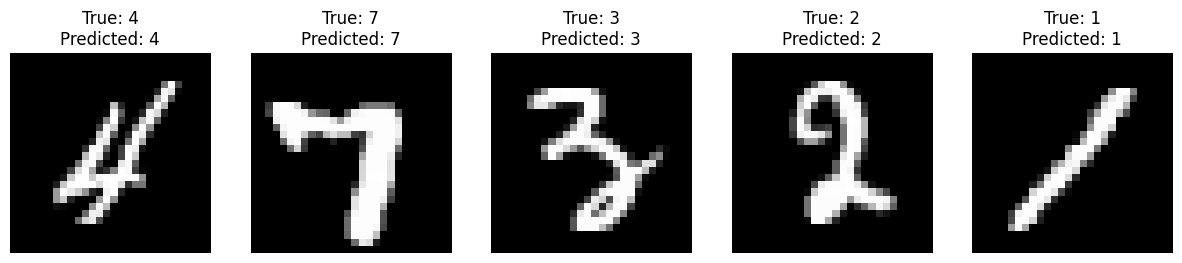

In [28]:
print("MLP Model Predictions:")
test_random_images(MLP_model, test_dataset, device)

## (ii) CNN Model

SimpleCNN Model Predictions:


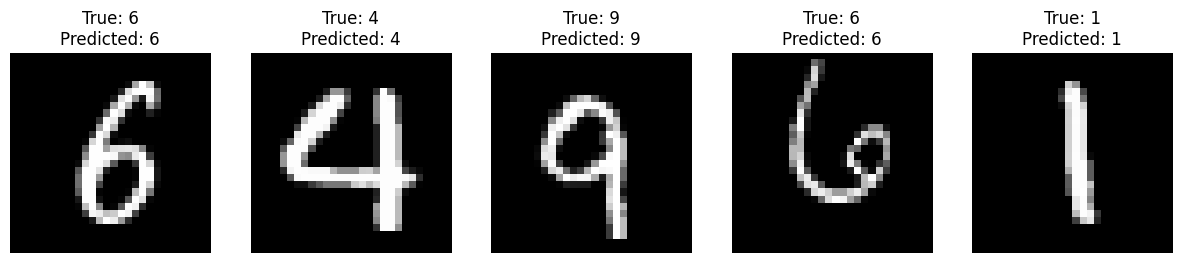

In [35]:
print("SimpleCNN Model Predictions:")
test_random_images(CNN_model, test_dataset, device)

## (iii) LeNet-5 Model

LeNet-5 Model Predictions:


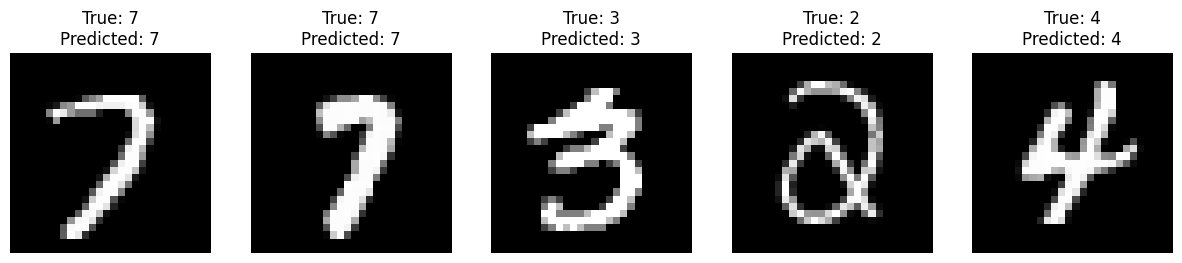

In [32]:
print("LeNet-5 Model Predictions:")
test_random_images(lenet_model, test_dataset, device)

# Building Our Own Custom Model

In [56]:
class CustomLeNet5(nn.Module):
    def __init__(self):
        super(CustomLeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 84)
        self.fc4 = nn.Linear(84, 10) 

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 32*2*2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


# Instantiate the custom model
custom_model = CustomLeNet5()

In [57]:
print(custom_model)

CustomLeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=84, bias=True)
  (fc4): Linear(in_features=84, out_features=10, bias=True)
)
